In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import shap

import matplotlib.pyplot as plt
# import optuna.integration.lightgbm as lgb
# import optuna

import warnings
warnings.filterwarnings(action='ignore')

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
data = pd.read_excel('./data/data.xlsx')

In [3]:
data.columns

Index(['CoilNO', '제품종류', '제품Size', '압연시작일시', '압연완료일시', 'Descaler.No1_Pressure',
       'Descaler.No2_Pressure', '조압연입측소재온도', '조압연입측소재온도.1',
       '중간사상압연_No2_출측소재온도', '선재사상압연입측소재온도', '선재사상압연출측소재온도', '최종압연 입측소재온도',
       '선재 Wire Rod 인출장치 출측소재온도', '조압연입측속도', '조압연출측속도', '중간압연1출측속도',
       '중간압연2출측속도', '중간사상압연_No2_출측속도', '선재사상압연출측속도', '최종압연 출측속도',
       '선재 Wire Rod 인출장치 진입속도', 'First.Cooling Zone#1(1WB)유량',
       'First.Cooling Zone#1(1WB)압력', 'First.Cooling Zone#2(2WB)유량',
       'First.Cooling Zone#2(2WB)압력', 'Middle.Cooling Zone#1(1WB)유량',
       'Middle.Cooling Zone#1(1WB)압력', 'Middle.Cooling Zone#2(2WB)유량',
       'Middle.Cooling Zone#2(2WB)압력', 'Middle.Cooling Zone#3(3WB)유량',
       'Middle.Cooling Zone#3(3WB)압력', 'Middle.Cooling Zone#4(4WB)유량',
       'Middle.Cooling Zone#4(4WB)압력', 'Last.Cooling Zone#1(1WB)유량',
       'Last.Cooling Zone#1(1WB)압력', 'Last.Cooling Zone#2(2WB)유량',
       'Last.Cooling Zone#2(2WB)압력', 'Rolling Time', 'Idle Time', '압연 Pitch',
       '선재사상압연모터전류'],

In [4]:
def preprocess(data, product_num, product_size = False):
    data = data[data['제품종류'] == 'Product_' + str(product_num)]
    
    if product_size:
        data = data[data['제품Size'] == product_size]
    
    y = data['선재사상압연모터전류'].values
    data['압연시간'] = (data['압연완료일시'] - data['압연시작일시']).dt.seconds
    data.drop(['CoilNO', '선재사상압연모터전류', '압연완료일시', '압연시작일시', '제품종류'], inplace=True, axis=1)
    
    if product_size:
        data.drop(['제품Size'], inplace=True, axis=1)

    x = data.values
    
#     scaler = StandardScaler()
    scaler = []
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

#     train_x = pd.DataFrame(scaler.fit_transform(train_x), columns=data.columns)
#     test_x = pd.DataFrame(scaler.transform(test_x), columns=data.columns)
    train_x = pd.DataFrame(train_x, columns=data.columns)
    test_x = pd.DataFrame(test_x, columns=data.columns)
    
#     return train_x, test_x, train_y, test_y, scaler
    return train_x, test_x, train_y, test_y

In [5]:
# train_x_17, test_x_17, train_y_17, test_y_17, scaler_17 = preprocess(data, 17)
# train_x_9, test_x_9, train_y_9, test_y_9, scaler_9 = preprocess(data, 9)

train_x_17, test_x_17, train_y_17, test_y_17 = preprocess(data, 17)
train_x_17_55, test_x_17_55, train_y_17_55, test_y_17_55 = preprocess(data, 17, 5.5)
train_x_9, test_x_9, train_y_9, test_y_9 = preprocess(data, 9)

In [6]:
# lgb dataset 만들기
categorical_features = [] # 필요시 제품Size 추가
training_rounds = 10000

train_ds_17 = lgb.Dataset(train_x_17, label = train_y_17, categorical_feature = categorical_features) 
test_ds_17 = lgb.Dataset(test_x_17, label = test_y_17, categorical_feature = categorical_features) 

train_ds_17_55 = lgb.Dataset(train_x_17_55, label = train_y_17_55, categorical_feature = categorical_features) 
test_ds_17_55 = lgb.Dataset(test_x_17_55, label = test_y_17_55, categorical_feature = categorical_features) 

train_ds_9 = lgb.Dataset(train_x_9, label = train_y_9, categorical_feature = categorical_features) 
test_ds_9 = lgb.Dataset(test_x_9, label = test_y_9, categorical_feature = categorical_features) 

In [7]:
params = {'objective': 'regression', 
          'metric': 'l2', 
          'verbosity': -1, 
          'boosting_type': 'gbdt', 
          'seed': 42, 
          'lambda_l1': 1.8181610459903688, 
          'lambda_l2': 3.036195578064946e-07, 
          'num_leaves': 450, 
          'feature_fraction': 0.5823535263763776, 
          'bagging_fraction': 0.9968221969358954, 
          'bagging_freq': 12, 
          # 'min_child_samples': 91,
          'min_child_samples' : 91,
          'seed' : 2018}

In [8]:
model_17 = lgb.train(params
                     , train_ds_17
                     , training_rounds
                     , test_ds_17
                     , verbose_eval = False
                     , categorical_feature = categorical_features
                     , early_stopping_rounds = 200
                    )

model_17_55 = lgb.train(params
                     , train_ds_17_55
                     , training_rounds
                     , test_ds_17_55
                     , verbose_eval = False
                     , categorical_feature = categorical_features
                     , early_stopping_rounds = 200
                    )

model_9 = lgb.train(params
                    , train_ds_9
                    , training_rounds
                    , test_ds_9
                    , verbose_eval = False
                    , categorical_feature = categorical_features
                    , early_stopping_rounds = 200
                   )

In [9]:
predict_17 = model_17.predict(test_x_17)
predict_17_55 = model_17_55.predict(test_x_17_55)
predict_9 = model_9.predict(test_x_9)

In [10]:
def vis_result(test_y, predict):
    print('Mean squared error: ', mean_squared_error(test_y, predict))
    print('R2 score: ', r2_score(test_y, predict))
    
    final_result = pd.concat([pd.DataFrame(test_y), pd.DataFrame(predict)], axis = 1)
    final_result.columns = ['label','predict']
    
    sns.regplot(x = 'label', y = 'predict', data = final_result, scatter_kws={'s':5})
    plt.show()

Mean squared error:  142.04591871883528
R2 score:  0.9927482356196362


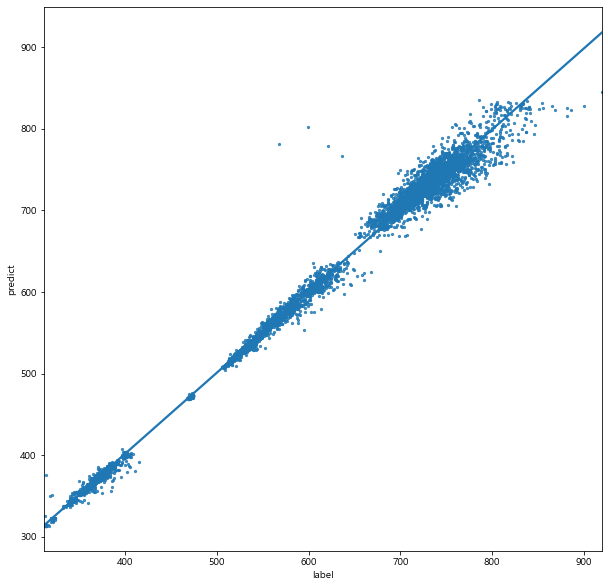

In [11]:
# Product 17
plt.figure(figsize=(10,10))
vis_result(test_y_17, predict_17)

Mean squared error:  351.36155760556716
R2 score:  0.7847112946957856


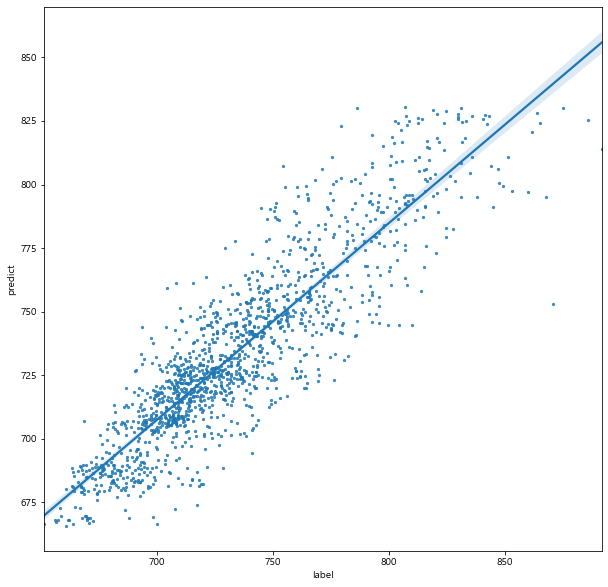

In [12]:
# Product 17, size 5.5
plt.figure(figsize=(10,10))
vis_result(test_y_17_55, predict_17_55)

Mean squared error:  212.86451367400667
R2 score:  0.9913450563941383


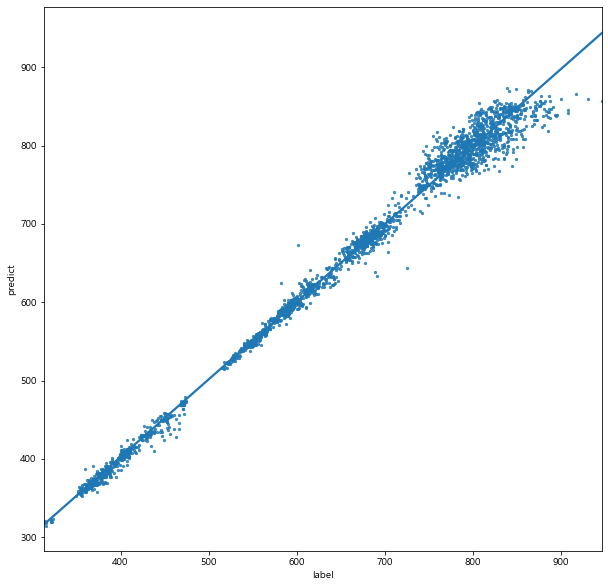

In [13]:
# Product 9
plt.figure(figsize=(10,10))
vis_result(test_y_9, predict_9)

# Feature Importance

## 제품 17

[Text(0.5, 1.0, 'Feature Importance (split)'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0, 0.5, 'Features')]

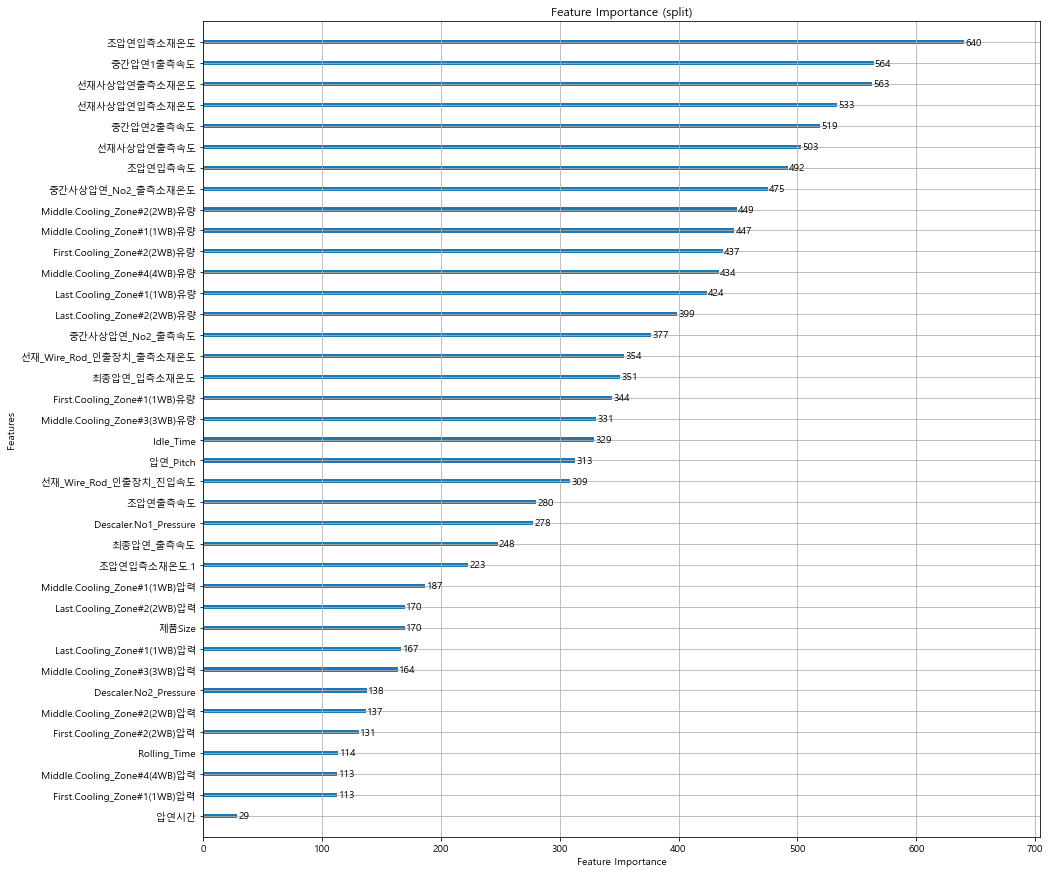

In [14]:
ax = lgb.plot_importance(model_17, max_num_features=len(data.columns), importance_type='split', figsize=(15,15))
ax.set(title=f'Feature Importance (split)',
	xlabel='Feature Importance',
	ylabel='Features')

[Text(0.5, 1.0, 'Feature Importance (gain)'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0, 0.5, 'Features')]

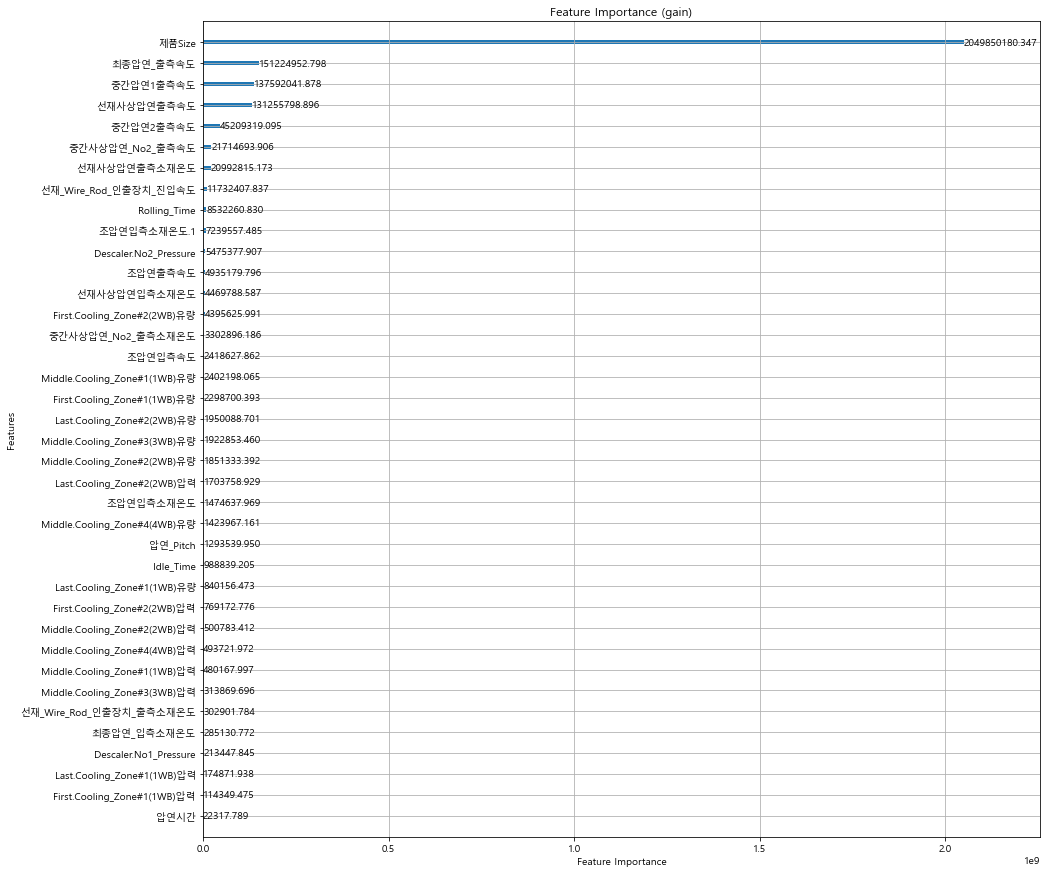

In [15]:
ax = lgb.plot_importance(model_17, max_num_features=len(data.columns), importance_type='gain', figsize=(15,15))
ax.set(title=f'Feature Importance (gain)',
	xlabel='Feature Importance',
	ylabel='Features')

In [16]:
# shap value 구하기
shap.initjs()
explainer_17 = shap.TreeExplainer(model_17)
shap_values_17 = explainer_17.shap_values(test_x_17)

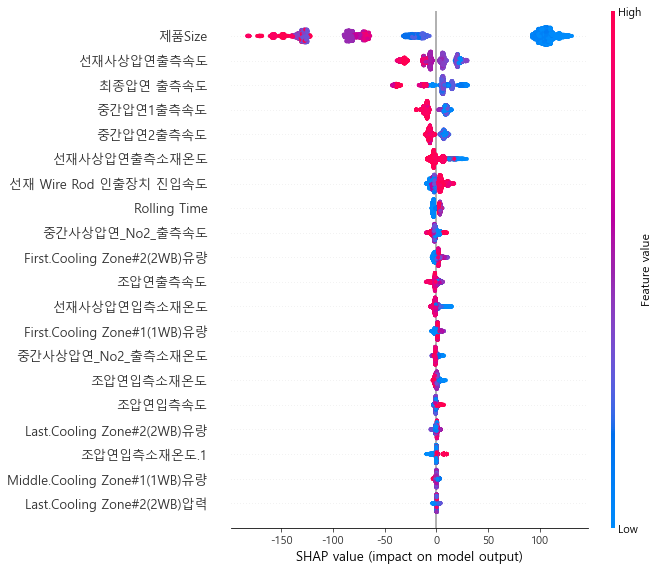

In [17]:
fig = shap.summary_plot(shap_values_17, test_x_17)

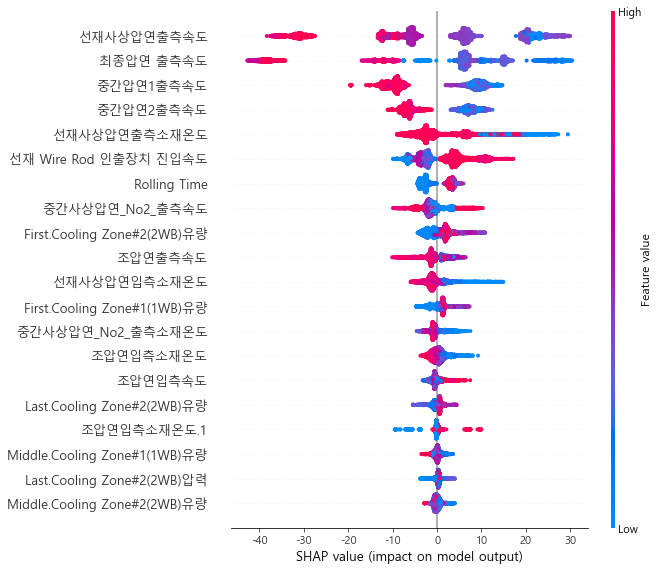

In [18]:
fig = shap.summary_plot(np.delete(shap_values_17, 0, 1), test_x_17.drop('제품Size', axis=1)) # size 빼고 보기

### 데이터 바꿔보기 (이상치)

In [19]:
print('실제값 : ' + str(test_y_17[6408]))

실제값 : 733.6347333


In [20]:
shap.force_plot(explainer_17.expected_value, shap_values_17[6408, :], test_x_17.iloc[6408, :])

In [21]:
test_x_17.loc[6408, '최종압연 출측속도']

1128.9

In [22]:
# 마지막 데이터를 복사한 후 '최종압연 출측속도' 값을 1800으로 변경
test_x_17 = test_x_17.append(test_x_17.iloc[6408, :], ignore_index=True)
test_x_17.at[6409, '최종압연 출측속도'] = 1800

In [23]:
explainer_17 = shap.TreeExplainer(model_17)
shap_values_17 = explainer_17.shap_values(test_x_17)

In [24]:
shap.force_plot(explainer_17.expected_value, shap_values_17[6409, :], test_x_17.iloc[6409, :])

----

## 제품 9

[Text(0.5, 1.0, 'Feature Importance (split)'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0, 0.5, 'Features')]

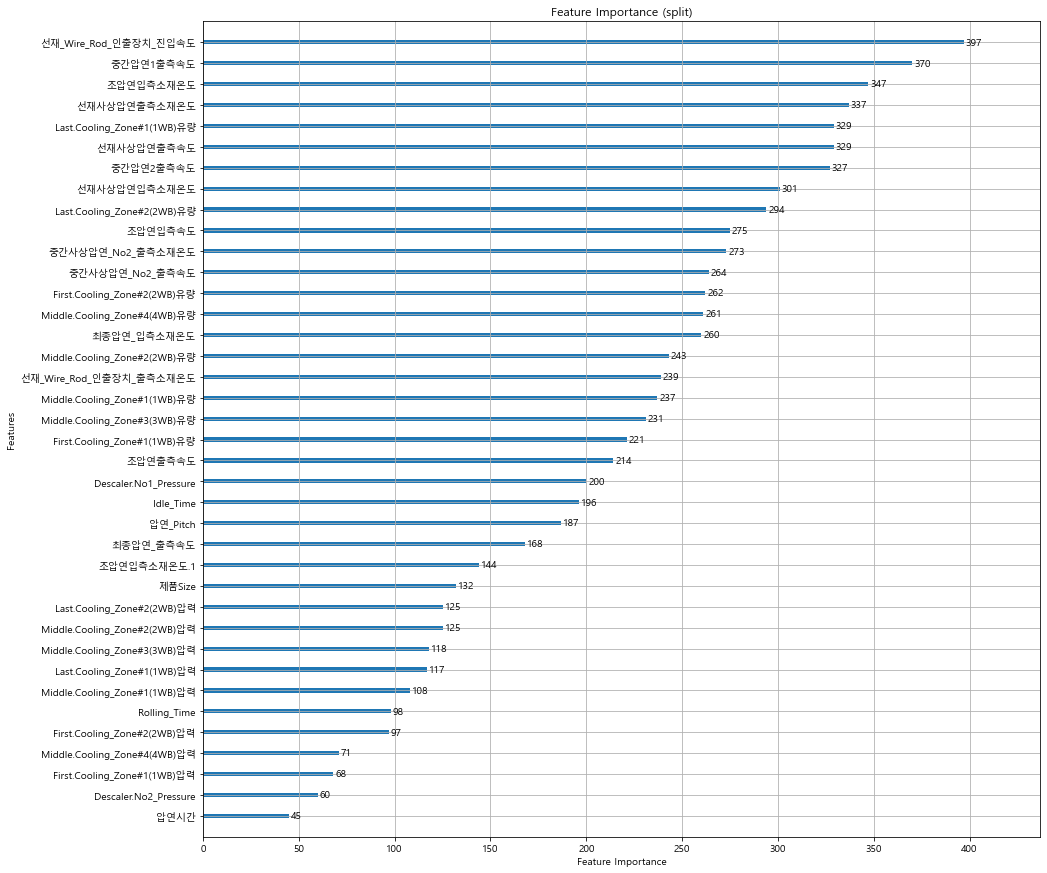

In [25]:
ax = lgb.plot_importance(model_9, max_num_features=len(data.columns), importance_type='split', figsize=(15,15))
ax.set(title=f'Feature Importance (split)',
	xlabel='Feature Importance',
	ylabel='Features')

[Text(0.5, 1.0, 'Feature Importance (gain)'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0, 0.5, 'Features')]

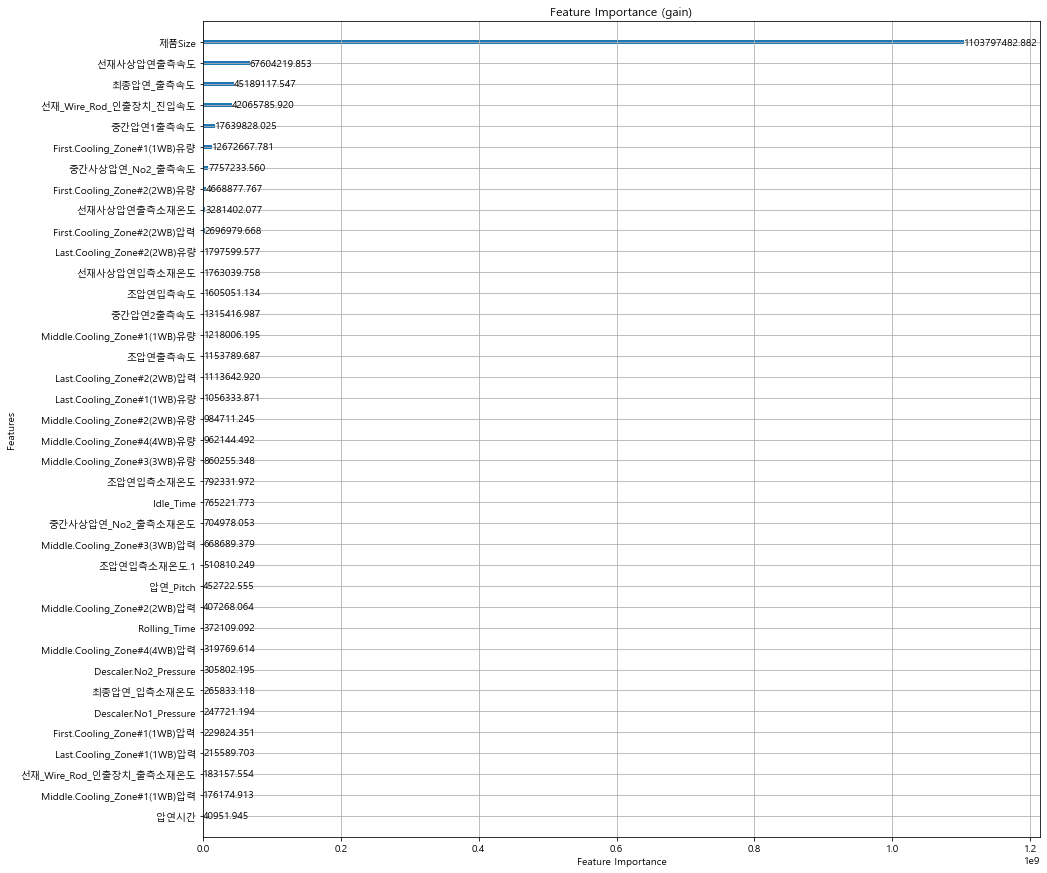

In [26]:
ax = lgb.plot_importance(model_9, max_num_features=len(data.columns), importance_type='gain', figsize=(15,15))
ax.set(title=f'Feature Importance (gain)',
	xlabel='Feature Importance',
	ylabel='Features')

In [27]:
# shap value 구하기
explainer_9 = shap.TreeExplainer(model_9)
shap_values_9 = explainer_9.shap_values(test_x_9)

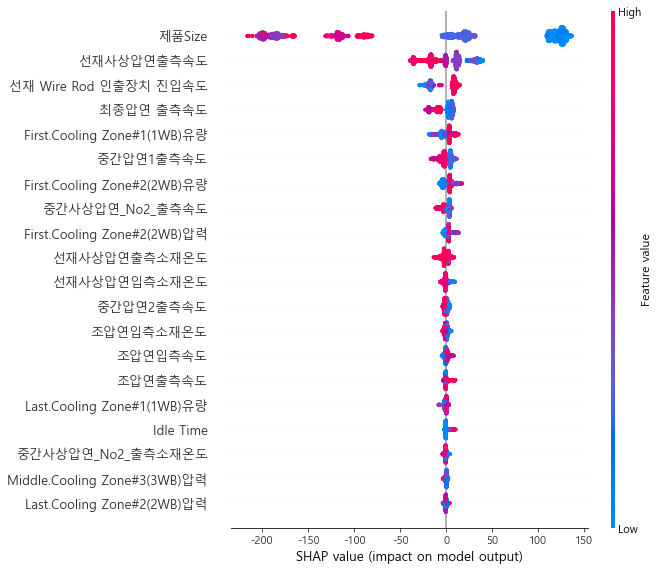

In [28]:
shap.summary_plot(shap_values_9, test_x_9)

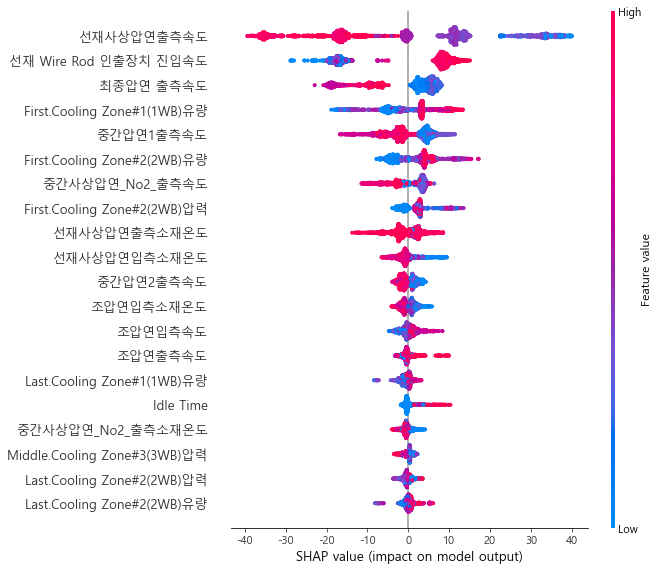

In [29]:
shap.summary_plot(np.delete(shap_values_9, 0, 1), test_x_9.drop('제품Size', axis=1))

----

## 제품 17 사이즈 5.5 (예시용)

In [30]:
# shap value 구하기

explainer_17_55 = shap.TreeExplainer(model_17_55)
shap_values_17_55 = explainer_17_55.shap_values(test_x_17_55)

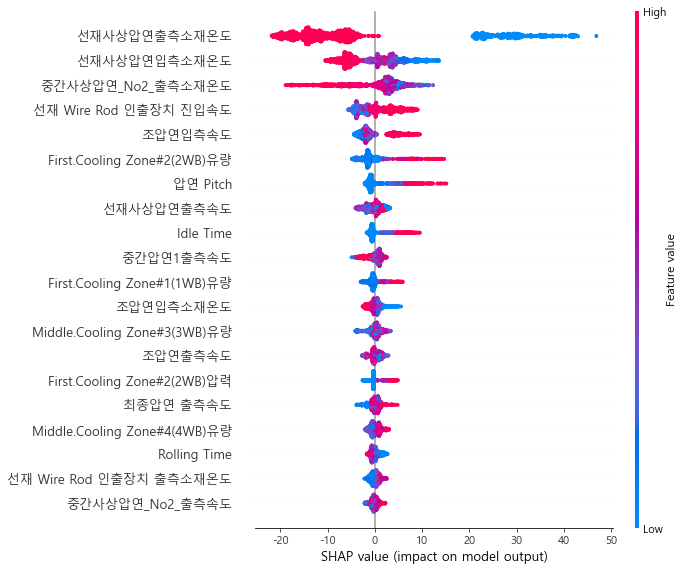

In [31]:
shap.summary_plot(shap_values_17_55, test_x_17_55)

In [33]:
shap.force_plot(explainer_17_55.expected_value, shap_values_17_55[1461, :], test_x_17_55.iloc[1461, :])

In [34]:
print('실제값 : ' + str(test_y_17_55[1461]))

실제값 : 808.0373


In [35]:
print(test_x_17_55.loc[1461, '선재사상압연출측소재온도'])

0.0


In [36]:
# 마지막 데이터를 복사한 후 '선재사상압연출측소재온도' 값을 1800으로 변경
test_x_17_55 = test_x_17_55.append(test_x_17_55.iloc[1461, :], ignore_index=True)
test_x_17_55.at[1462, '선재사상압연출측소재온도'] = 1800

In [37]:
explainer_17_55 = shap.TreeExplainer(model_17_55)
shap_values_17_55 = explainer_17_55.shap_values(test_x_17_55)

In [38]:
shap.force_plot(explainer_17_55.expected_value, shap_values_17_55[1462, :], test_x_17_55.iloc[1462, :])